In [14]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [101]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-25 Test plate"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                 FileName_RGB  ImageNumber
0  2024-07-25 Test plate 2 (Multichannel).tif            1


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-25 Test plate\2024-07-25 Test plate 2 (Multichannel).toml


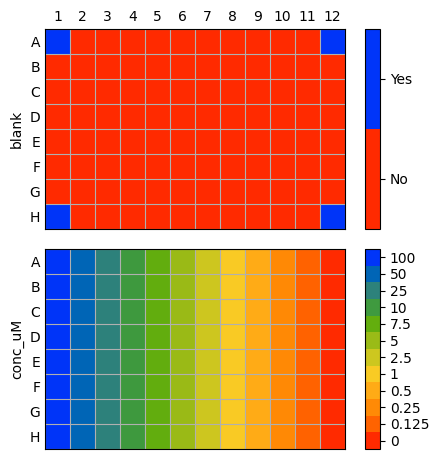

In [103]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [104]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

   row  col
0    A    1
1    B    1
2    C    1
3    D    1
4    E    1
..  ..  ...
91   D   12
92   E   12
93   F   12
94   G   12
95   H   12

[96 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [105]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance', 'substance_incubation',
       'culture_type', 'control'],
      dtype='object')


Blank and control calculation for each plate

In [106]:
blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    bc_array_i = [blank_p,control_p,p]

    blank_control_array.append(bc_array_i)


blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank_mean', 'control_mean','FileName_RGB']) 

print(blank_control_df)




   blank_mean  control_mean                                FileName_RGB
0    0.017624       0.02017  2024-07-25 Test plate 2 (Multichannel).tif


Blank exclusion and relative values calculating

In [107]:
data_plate_wo_blank_wells = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

data_plate_with_mean_blank_control = pd.merge(data_plate_wo_blank_wells, blank_control_df, on=['FileName_RGB'])

data_plate_with_mean_blank_control['Green_blanked'] = data_plate_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen'] - data_plate_with_mean_blank_control['blank_mean']
data_plate_with_mean_blank_control['Green_relative'] = data_plate_with_mean_blank_control['Green_blanked']/data_plate_with_mean_blank_control['control_mean']*100

Data selection

In [108]:
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'Vero') & 
#                                                    (data_plate_with_mean_blank_control['sample'] == 'CK')]

# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['substance'] == 'ISK-1')]
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'hTERT')]
data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['control'] == 'Yes')]

# print(data_selected['Intensity_IntegratedIntensity_OrigRed'][(data_selected['control'] == 'Yes')])

Plotting


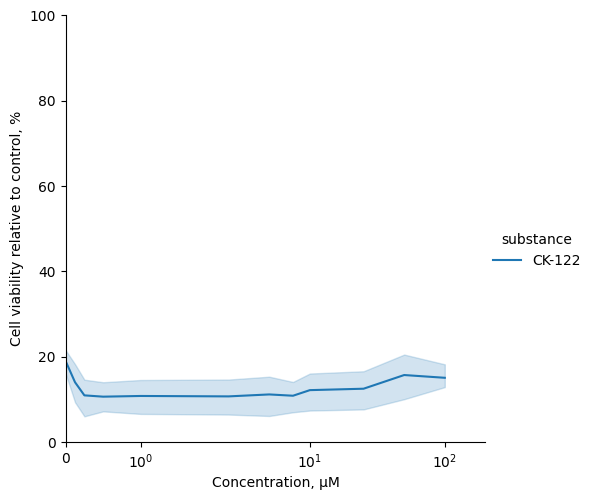

In [109]:
ax = sns.relplot(data=data_selected, x="conc_uM", y="Green_relative", kind="line", hue = 'substance')


# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()



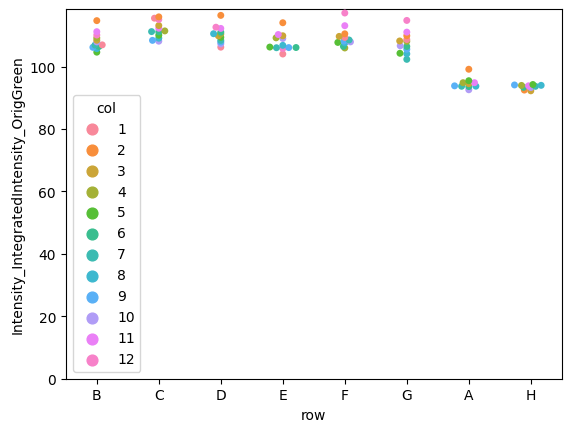

In [117]:
ax = sns.swarmplot(data=data_selected, x="row", y="Intensity_IntegratedIntensity_OrigGreen", hue = 'col')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


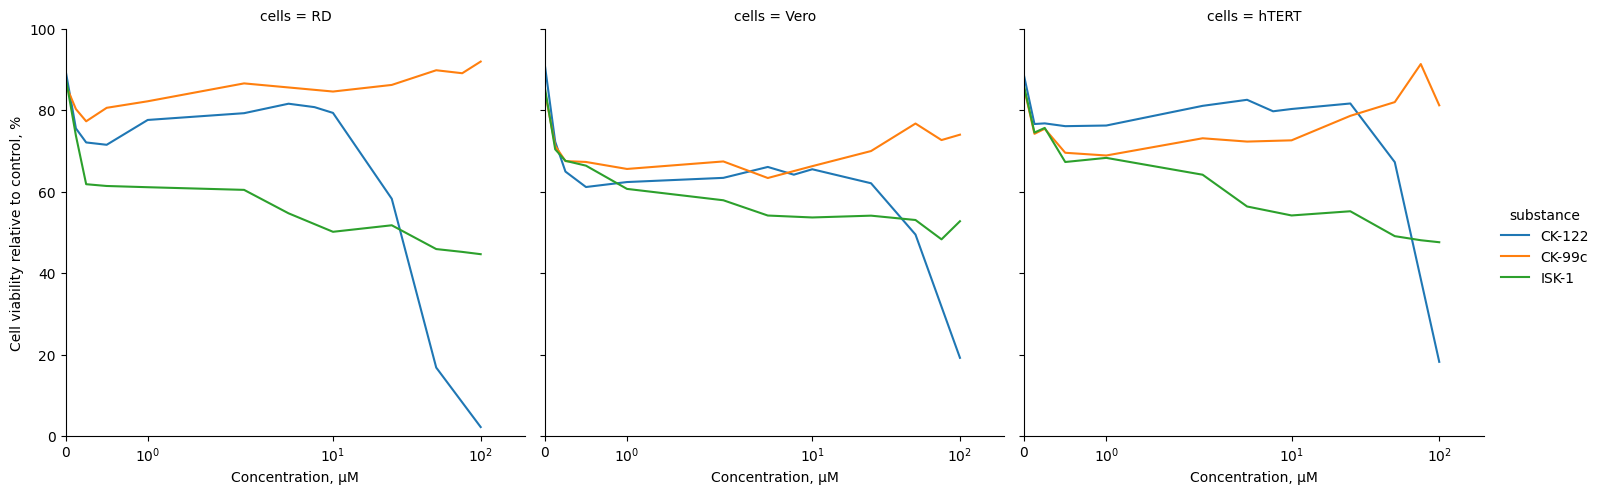

In [88]:
ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", 
                 hue = 'substance', col='cells', ci=None)

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()

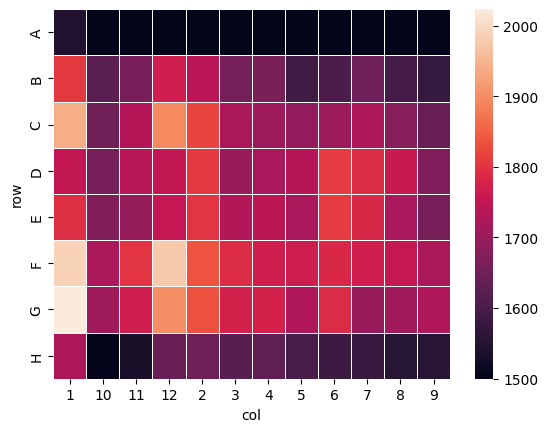

In [132]:
# ax = sns.heatmap(data=data_selected)
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))

heatmap_df = data_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigRed")

# print(heatmap_df)

sns.heatmap(heatmap_df, linewidth=.5, vmin=1500, vmax=None)

plt.show()